In [ ]:
# Install required packages
!pip install opencv-python-headless
!pip install mtcnn
!pip install keras-facenet
!pip install seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10369 sha256=12ca7fa20add651eba21076f2525ebdf781a8c6fc1b015af31b8d715a6e88b58
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [ ]:
# import the library

import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from mtcnn import MTCNN
from keras_facenet import FaceNet

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Extract the dataset

zip_path = '/content/drive/My Drive/Dataset Research/datsetsatsetnew.zip'
extract_path = '/content/dataset_frans'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Define directories for images
base_dir = '/content/dataset_frans/DatSet'
face_shapes = ['diamond', 'oval', 'round', 'square']
hair_lengths = ['medium hair', 'short hair']
hair_styles = ['Curly', 'Straight', 'Wavy']

In [ ]:
# Prepare a combined list of images and labels
images = []
labels = []

for face_shape in face_shapes:
    for hair_length in hair_lengths:
        for hair_style in hair_styles:
            folder_path = os.path.join(base_dir, face_shape, hair_length, hair_style)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (160, 160))  # Resize image to 160x160 for FaceNet
                    images.append(img)
                    labels.append((face_shape, hair_length, hair_style))

In [ ]:
# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [ ]:
# Encode the labels
face_shape_encoder = LabelEncoder()
hair_length_encoder = LabelEncoder()
hair_style_encoder = LabelEncoder()

face_shape_labels = face_shape_encoder.fit_transform(labels[:, 0])
hair_length_labels = hair_length_encoder.fit_transform(labels[:, 1])
hair_style_labels = hair_style_encoder.fit_transform(labels[:, 2])

In [ ]:
# Load MTCNN and FaceNet models
detector = MTCNN()
embedder = FaceNet()

def extract_face_embeddings(img, detector, embedder):
    detection = detector.detect_faces(img)
    if detection:
        x, y, width, height = detection[0]['box']
        face = img[y:y+height, x:x+width]
        face = cv2.resize(face, (160, 160))
        face = np.expand_dims(face, axis=0)
        embedding = embedder.embeddings(face)
        return embedding.flatten()
    return None

In [ ]:
#Extract features for all images
features = []
filtered_labels = []
for img, label in zip(images, labels):
    embedding = extract_face_embeddings(img, detector, embedder)
    if embedding is not None:
        features.append(embedding)
        filtered_labels.append(label)
features = np.array(features)
filtered_labels = np.array(filtered_labels)

1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 30ms/step


In [ ]:
# Split the dataset with extracted features
X_train, X_temp, y_train, y_temp = train_test_split(
    features, filtered_labels, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42)

In [ ]:
# Separate the labels for face shape, hair length, and hair style
y_train_face = face_shape_encoder.transform(y_train[:, 0])
y_train_length = hair_length_encoder.transform(y_train[:, 1])
y_train_style = hair_style_encoder.transform(y_train[:, 2])

y_val_face = face_shape_encoder.transform(y_val[:, 0])
y_val_length = hair_length_encoder.transform(y_val[:, 1])
y_val_style = hair_style_encoder.transform(y_val[:, 2])

y_test_face = face_shape_encoder.transform(y_test[:, 0])
y_test_length = hair_length_encoder.transform(y_test[:, 1])
y_test_style = hair_style_encoder.transform(y_test[:, 2])


In [ ]:
# Train KNN classifier
knn_face = KNeighborsClassifier(n_neighbors=5)
knn_length = KNeighborsClassifier(n_neighbors=5)
knn_style = KNeighborsClassifier(n_neighbors=5)

knn_face.fit(X_train, y_train_face)
knn_length.fit(X_train, y_train_length)
knn_style.fit(X_train, y_train_style)

KNeighborsClassifier()

In [ ]:
# Evaluate KNN classifiers
face_acc = knn_face.score(X_test, y_test_face)
length_acc = knn_length.score(X_test, y_test_length)
style_acc = knn_style.score(X_test, y_test_style)

print(f'Test Face Shape Accuracy: {face_acc * 100:.2f}%')
print(f'Test Hair Length Accuracy: {length_acc * 100:.2f}%')
print(f'Test Hair Style Accuracy: {style_acc * 100:.2f}%')

Test Face Shape Accuracy: 53.85%
Test Hair Length Accuracy: 53.85%
Test Hair Style Accuracy: 38.46%


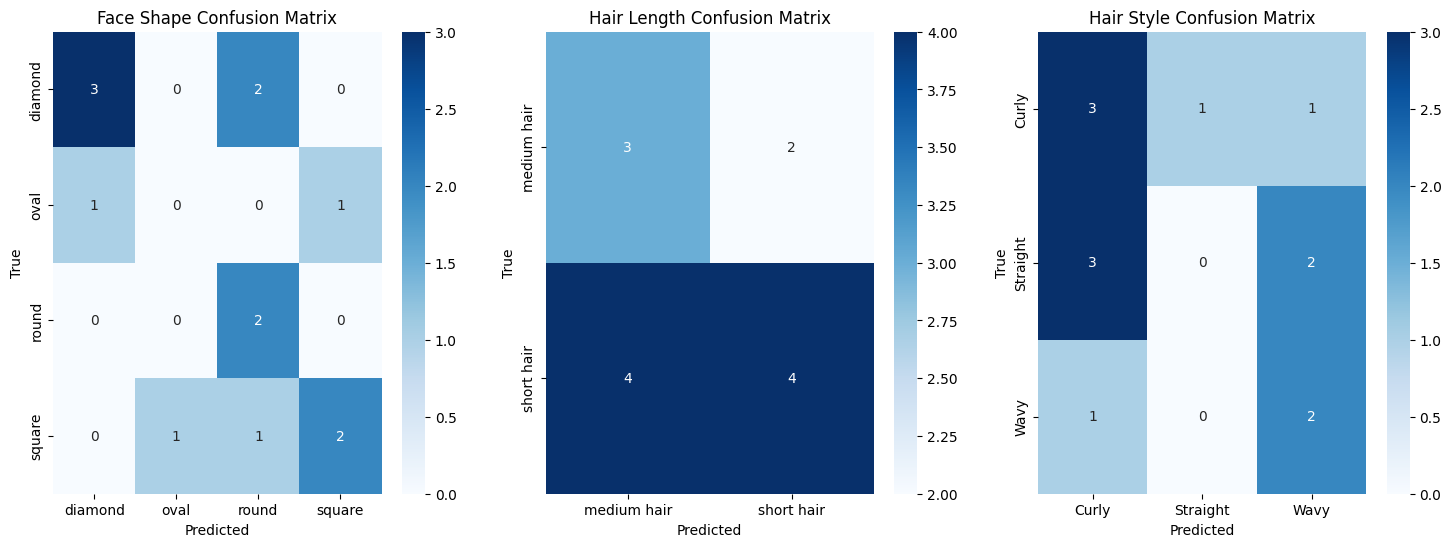

In [ ]:
# Plot the evaluation metrics
y_pred_face = knn_face.predict(X_test)
y_pred_length = knn_length.predict(X_test)
y_pred_style = knn_style.predict(X_test)

conf_matrix_face = confusion_matrix(y_test_face, y_pred_face)
conf_matrix_length = confusion_matrix(y_test_length, y_pred_length)
conf_matrix_style = confusion_matrix(y_test_style, y_pred_style)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_face, annot=True, fmt='d', cmap='Blues', xticklabels=face_shapes, yticklabels=face_shapes)
plt.title('Face Shape Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_length, annot=True, fmt='d', cmap='Blues', xticklabels=hair_lengths, yticklabels=hair_lengths)
plt.title('Hair Length Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix_style, annot=True, fmt='d', cmap='Blues', xticklabels=hair_styles, yticklabels=hair_styles)
plt.title('Hair Style Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

In [ ]:
# making function to Classify live from Camera

def live_predict(knn_face, knn_length, knn_style, detector, embedder):
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        img = cv2.resize(frame, (160, 160))
        embedding = extract_face_embeddings(img, detector, embedder).reshape(1, -1)

        pred_face = knn_face.predict(embedding)[0]
        pred_length = knn_length.predict(embedding)[0]
        pred_style = knn_style.predict(embedding)[0]

        face_shape = face_shape_encoder.inverse_transform([pred_face])[0]
        hair_length = hair_length_encoder.inverse_transform([pred_length])[0]
        hair_style = hair_style_encoder.inverse_transform([pred_style])[0]

        cv2.putText(frame, f'Face Shape: {face_shape}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f'Hair Length: {hair_length}', (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f'Hair Style: {hair_style}', (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow('Live Prediction', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
import random

from google.colab.patches import cv2_imshow

def display_image_with_title(img, title):
    # Display the image with a title using OpenCV
    img = cv2.resize(img, (458, 500))
    cv2.putText(img, title, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2_imshow(img)

def display_random_image(base_dir, face_shape, hair_length, hair_style):
    folder_path = os.path.join(base_dir, face_shape, hair_length, hair_style)
    img_names = os.listdir(folder_path)
    if img_names:
        random_img_name = random.choice(img_names)
        img_path = os.path.join(folder_path, random_img_name)
        img = cv2.imread(img_path)
        if img is not None:
            cv2_imshow(img)

def predict_from_drive(knn_face, knn_length, knn_style, detector, embedder, img_path, base_dir):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (160, 160))
    embedding = extract_face_embeddings(img_resized, detector, embedder).reshape(1, -1)

    pred_face = knn_face.predict(embedding)[0]
    pred_length = knn_length.predict(embedding)[0]
    pred_style = knn_style.predict(embedding)[0]

    face_shape = face_shape_encoder.inverse_transform([pred_face])[0]
    hair_length = hair_length_encoder.inverse_transform([pred_length])[0]
    hair_style = hair_style_encoder.inverse_transform([pred_style])[0]

    # Display the uploaded image with title "Your Image"
    display_image_with_title(img, "Your Image")

    print(f'Hair Length Recommendation : {hair_length}')
    print(f'Hair Style Recommendation : {hair_style}')


    # Display random image from the predicted classes
    display_random_image(base_dir, face_shape, hair_length, hair_style)

    return face_shape, hair_length, hair_style

1/1 [==============================] - 0s 28ms/step


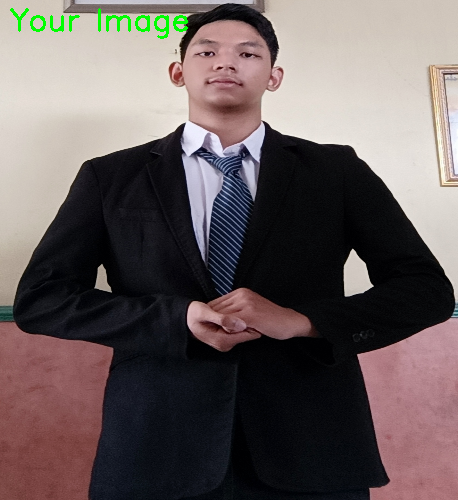

Hair Length Recommendation : short hair
Hair Style Recommendation : Curly


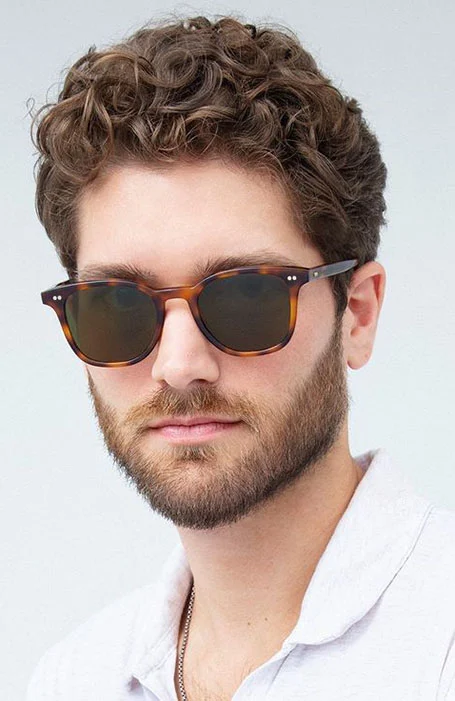

('diamond', 'short hair', 'Curly')

In [ ]:
# implementing the function

img_path = '/content/drive/MyDrive/Dataset Research/IMG_20221108_143756.jpg'
predict_from_drive(knn_face, knn_length, knn_style, detector, embedder, img_path, base_dir)